#### Sunrise Sunset analysis
This notebook is used to analyze the car accident data in the US and find out the potential relationship between the sunrise/sunset time and the accident rate.

#### Data cleaning

In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys


c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# read in the data
accidents_data = pd.read_csv('./data/processed_us_car_accidents_2022.csv')

# show columns
print(accidents_data.columns)

Index(['Unnamed: 0', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lattitude', 'Start_Longitude', 'End_Lattitude', 'End_Longitude',
       'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Traffic_Signal', 'Sunrise_Sunset', 'State_Abbrv',
       'Population'],
      dtype='object')


In [3]:
# fisrt filter out the data in South Carolina
accidents_data = accidents_data[accidents_data['State'] == 'SC']

To automate the task of determining whether an accident occurred on a highway and its orientation (North, South, East, West), we can write a Python script that processes the descriptions. The script will use regular expressions to search for keywords indicating highway involvement and direction. If a highway is mentioned with a direction, it will return the respective orientation. If no highway or direction is indicated, it will return "No_details".

In [4]:
def analyze_description(description):
    # Regular expressions to find highway and direction mentions
    highway_pattern = re.compile(r'\b(I-\d+|US-\d+|[A-Z]{2}-\d+)\b', re.IGNORECASE)
    direction_pattern = re.compile(r'\b(Northbound|Southbound|Eastbound|Westbound|NB|SB|EB|WB|North|South|East|West|N|S|E|W)\b', re.IGNORECASE)

    # capitalize the description
    description = description.upper()

    # Search for patterns in the description
    highway_match = highway_pattern.search(description)
    direction_match = direction_pattern.search(description)

    # Determine if the incident is on a highway and its orientation
    if highway_match:
        if direction_match:
            # Extract the first word of the direction match as the orientation
            direction = direction_match.group(0).split()[0]
            return direction[0]  # Return only the first letter of the direction
        else:
            return "No_Details"
    else:
        return "No_Details"

In [5]:
# Apply the function to the description column and take a look at both columns
accidents_data['highway_direction'] = accidents_data['Description'].apply(analyze_description)

In [6]:
# sample 20 rows for highway_direction and description
print(accidents_data[['highway_direction', 'Description']].sample(20))

        highway_direction                                        Description
1624168                 W  Stationary traffic on US-176 W - US-176 E from...
1687622                 W  Stationary traffic on I-26 W from SC-146/Exit ...
1686229        No_Details  Incident on US-21 near SAM WALKER RD Drive wit...
1615360        No_Details  Incident on PARKLANE RD near FARROW RD Drive w...
103727         No_Details              Crash on Hunters Ln at Ravenswood Dr.
110635         No_Details   Crash on US-29 Wade Hampton Blvd at Buncombe Rd.
849708         No_Details  Incident on OLD SPARTANBURG RD near HALCYON CI...
1209015        No_Details  Incident on GREEN VILLAGE RD near SANDRIDGE RD...
418051         No_Details  Incident on SUTTON SPRING RD near BLACK HWY Dr...
1014269                 S  Stationary traffic from SC-81/Anderson Rd (S W...
150813         No_Details                       Crash on US-501 near SC-544.
622970                  S  Incident on I-85 SB near MM 30 Drive with caut...

In [7]:
# Filter out the accidents with no highway details
accidents_data = accidents_data[accidents_data['highway_direction'] != 'No_Details']

# count the number of accidents in each direction
accidents_by_direction = accidents_data['highway_direction'].value_counts()
accidents_by_direction

N    7208
S    7131
W    5997
E    5665
Name: highway_direction, dtype: int64

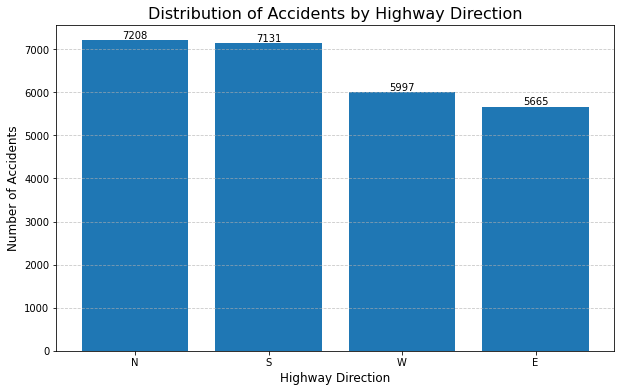

<Figure size 432x288 with 0 Axes>

In [8]:
# now plot the data
import matplotlib.pyplot as plt
# Sort the values for a consistent look
accidents_by_direction_sorted = accidents_by_direction.sort_values(ascending=False)

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set a figure size
bars = plt.bar(accidents_by_direction_sorted.index, accidents_by_direction_sorted.values)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Highway Direction', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.title('Distribution of Accidents by Highway Direction', fontsize=16)

# Add a grid to the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot with enhancements
plt.show()

# Save the plot
plt.savefig('./graph/accidents_by_direction.png', dpi=300)

The number of accidents is relatively evenly distributed across all four directions, with a slightly higher number of accidents in the North and South directions.
There is no single direction that significantly stands out as having a much higher number of accidents.

In [9]:
# do a time series analysis of the data
import datetime as dt
from suntime import Sun, SunTimeException

In [10]:
# filter out the data that is not on highways
accidents_data = accidents_data[accidents_data['highway_direction'] != 'No_Details']

In [11]:
def calculate_sunrise_sunset(latitude, longitude, date):
    # Calculate the sunrise and sunset times for the given date
    sun = Sun(latitude, longitude)
    try:
        return sun.get_local_sunrise_time(date), sun.get_local_sunset_time(date)
    except SunTimeException:
        # Return None if the sun does not rise or set on the given date
        return None, None

In [12]:
# seprate the date and time from the start time column
accidents_data["date"] = pd.to_datetime(accidents_data["Start_Time"]).dt.date
accidents_data["time"] = pd.to_datetime(accidents_data["Start_Time"]).dt.time

In [13]:
# get the sunrise and sunset times
accidents_data["sunrise"], accidents_data["sunset"] = zip(*accidents_data.apply(lambda x: calculate_sunrise_sunset(x["Start_Lattitude"], x["Start_Longitude"], x["date"]), axis=1))

In [14]:
def segment_sunrise(row):
    # Convert Start_Time and sunrise to datetime if it's not already
    row["Start_Time"] = pd.to_datetime(row["Start_Time"]).tz_localize(None)
    row["sunrise"] = row["sunrise"].tz_localize(None)

    # Define the start and end times for the segments
    start_time = row["sunrise"] - dt.timedelta(hours=2)
    end_time = row["sunrise"] + dt.timedelta(hours=2)

    # get time difference in hours
    time_diff_hours = (row["Start_Time"] - row["sunrise"]).total_seconds() / 3600

    # Define the segments
    segments = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

    # label the segments with -2, -1:45, -1:30, -1:15, -1, -0:45, -0:30, -0:15, 0, 0:15, 0:30, 0:45, 1, 1:15, 1:30, 1:45, 2, if the time of the accident is within the segment, otherwise leave it as empty string
    for i in segments:
        if time_diff_hours >= i and time_diff_hours < i + 0.25:
            return i

    return np.nan

# apply the function to the dataframe
accidents_data["sunrise_segment"] = accidents_data.apply(segment_sunrise, axis=1)
# count the number of accidents in each segment
accidents_by_sunrise_segment = accidents_data["sunrise_segment"].value_counts()
accidents_by_sunrise_segment

 2.00    473
 1.50    456
 1.25    414
 1.75    395
 0.75    374
 1.00    356
 0.50    322
 0.25    294
 0.00    283
-0.25    153
-0.50    124
-0.75    118
-2.00     89
-1.00     86
-1.25     84
-1.75     84
-1.50     81
Name: sunrise_segment, dtype: int64

In [15]:
# do the same for sunset
def segment_sunset(row):
    # Convert Start_Time and sunset to datetime if it's not already
    row["Start_Time"] = pd.to_datetime(row["Start_Time"]).tz_localize(None)
    row["sunset"] = row["sunset"].tz_localize(None)

    # Define the start and end times for the segments
    start_time = row["sunset"] - dt.timedelta(hours=2.25)
    end_time = row["sunset"] + dt.timedelta(hours=2.25)

    # get time difference in hours
    time_diff_hours = (row["Start_Time"] - row["sunset"]).total_seconds() / 3600

    # Define the segments
    segments = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25]

    # label the segments with -2, -1:45, -1:30, -1:15, -1, -0:45, -0:30, -0:15, 0, 0:15, 0:30, 0:45, 1, 1:15, 1:30, 1:45, 2, if the time of the accident is within the segment, otherwise leave it as empty string
    for i in segments:
        if time_diff_hours >= i and time_diff_hours < i + 0.25:
            return i

    return np.nan

# apply the function to the dataframe
accidents_data["sunset_segment"] = accidents_data.apply(segment_sunset, axis=1)
# count the number of accidents in each segment
accidents_by_sunset_segment = accidents_data["sunset_segment"].value_counts()
# sort by index starting from -2 to 2
accidents_by_sunset_segment.sort_index(inplace=True)
accidents_by_sunset_segment

-2.00    367
-1.75    364
-1.50    365
-1.25    357
-1.00    364
-0.75    342
-0.50    345
-0.25    327
 0.00    345
 0.25    290
 0.50    279
 0.75    232
 1.00    204
 1.25    204
 1.50    209
 1.75    161
 2.00    147
 2.25    136
Name: sunset_segment, dtype: int64

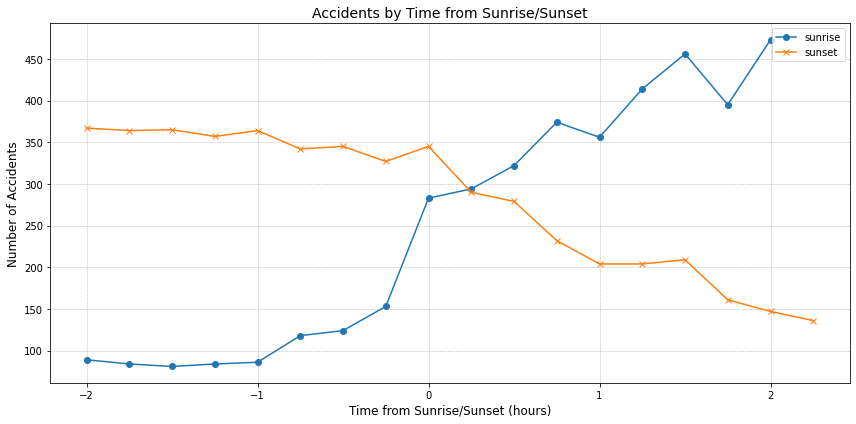

<Figure size 432x288 with 0 Axes>

In [16]:
# now let's visualize the data by plotting the number of accidents in each segment
# create a line plot with X axis as the time segment and Y axis as the number of accidents for both sunrise and sunset
# Group the data by sunrise segment and count the number of accidents in each segment
sunrise_counts = accidents_data['sunrise_segment'].value_counts().sort_index()

# Group the data by sunset segment and count the number of accidents in each segment
sunset_counts = accidents_data['sunset_segment'].value_counts().sort_index()

plt.figure(figsize=(12, 6))  # Larger figure size for better readability

# Improved line plots with markers and smoother lines (if applicable)
plt.plot(sunrise_counts.index, sunrise_counts.values, label='sunrise', marker='o', linestyle='-', color='C0')
plt.plot(sunset_counts.index, sunset_counts.values, label='sunset', marker='x', linestyle='-', color='C1')

# Adding a legend with a non-obstructive placement
plt.legend(loc='upper right')

# Adding a grid for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding labels and title with improved font sizes
plt.xlabel('Time from Sunrise/Sunset (hours)', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.title('Accidents by Time from Sunrise/Sunset', fontsize=14)

# Improving the layout to prevent clipping of the xlabel
plt.tight_layout()

# Showing the plot with enhancements
plt.show()

# Save the plot
plt.savefig('./graph/accidents_by_time_from_sunrise_sunset.png', dpi=300)

Accident Frequency Variation: There is a noticeable variation in accident frequency throughout the day. For instance, the number of accidents spikes at certain times after sunrise and before sunset. This could suggest that factors like changing light conditions may have an impact on driving safety.

Comparison between Sunrise and Sunset: The trends for sunrise and sunset are distinct, indicating different patterns of accidents at these times. For example, there might be more accidents in the hours following sunset than the hours after sunrise, which could imply visibility or traffic volume issues during these times.

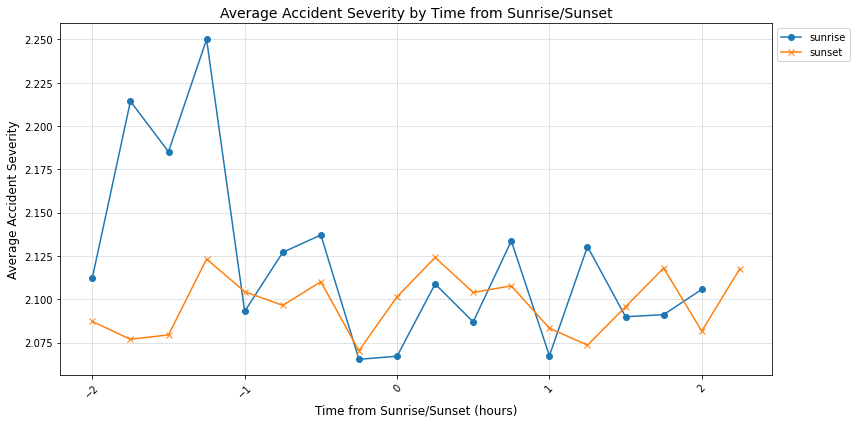

<Figure size 432x288 with 0 Axes>

In [17]:
# Do the same but only focous on average accident severity
# Filter the data for sunrise period
sunrise_data = accidents_data[accidents_data['sunrise_segment'].notnull()]

# Group the data by sunrise segment and calculate the average accident severity in each segment
sunrise_avg_severity = sunrise_data.groupby('sunrise_segment')['Severity'].mean()

# Filter the data for sunset period
sunset_data = accidents_data[accidents_data['sunset_segment'].notnull()]

# Group the data by sunset segment and calculate the average accident severity in each segment
sunset_avg_severity = sunset_data.groupby('sunset_segment')['Severity'].mean()

plt.figure(figsize=(12, 6))  # Larger figure size for better visibility

# Plot lines with markers
plt.plot(sunrise_avg_severity.index, sunrise_avg_severity.values, label='sunrise', marker='o', linestyle='-', color='C0')
plt.plot(sunset_avg_severity.index, sunset_avg_severity.values, label='sunset', marker='x', linestyle='-', color='C1')

# Format the legend to be outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add grid for easier value reading
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add labels and title with improved font sizes
plt.xlabel('Time from Sunrise/Sunset (hours)', fontsize=12)
plt.ylabel('Average Accident Severity', fontsize=12)
plt.title('Average Accident Severity by Time from Sunrise/Sunset', fontsize=14)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45)

# Ensure that the layout fits well and nothing is clipped
plt.tight_layout()

# Show the plot with enhancements
plt.show()

# Save the plot
plt.savefig('./graph/avg_accident_severity_by_time_from_sunrise_sunset.png', dpi=300)

Minor Variations in Severity: The graph indicates that the average accident severity does exhibit some variations during different times around sunrise and sunset, but these variations are minor. The severity does not show a strong or consistent pattern that could be directly attributed to the time of day with respect to sunrise and sunset.

Lack of Clear Trend: There doesn't appear to be a clear trend in the data that would suggest a significant increase or decrease in the average severity of accidents based on the time from sunrise or sunset. This could imply that factors other than the time relative to sunrise and sunset have a more pronounced impact on the severity of accidents.

<Figure size 864x432 with 0 Axes>

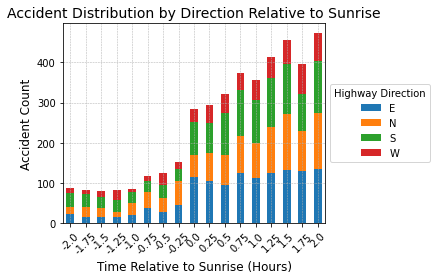

<Figure size 432x288 with 0 Axes>

In [18]:
import seaborn as sns
# Now focous only on Sunrise period, and plot the number of accidents in each direction for each segment
# Filter the data for sunrise period
sunrise_data = accidents_data[accidents_data['sunrise_segment'].notnull()]

# Group the data by sunrise segment and direction, and count the number of accidents in each segment-direction combination
sunrise_counts_by_direction = sunrise_data.groupby(['sunrise_segment', 'highway_direction']).size().unstack()

plt.figure(figsize=(12, 6))  # Set figure size for consistency

# Create the stacked bar plot using default matplotlib colors
sunrise_counts_by_direction.plot(kind='bar', stacked=True)

# Rename the labels and title according to the previous suggestions
plt.xlabel('Time Relative to Sunrise (Hours)', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.title('Accident Distribution by Direction Relative to Sunrise', fontsize=14)

# Rotate x-axis labels to match the line plot
plt.xticks(rotation=45)

# Add a grid for ease of reading
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Place the legend to the side of the plot
plt.legend(title='Highway Direction', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure layout is tight so labels/titles are not cut off
plt.tight_layout()

# Show the plot
plt.show()

# save the plot
plt.savefig('./graph/accident_distribution_by_direction_relative_to_sunrise.png', dpi=300)


<Figure size 864x432 with 0 Axes>

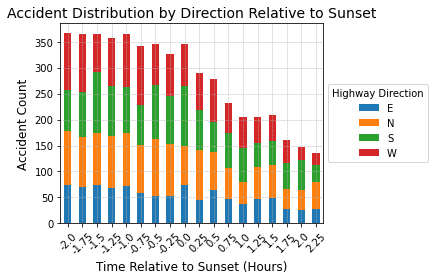

<Figure size 432x288 with 0 Axes>

In [19]:
# do the same for sunset
# Filter the data for sunset period
sunset_data = accidents_data[accidents_data['sunset_segment'].notnull()]

# Group the data by sunset segment and direction, and count the number of accidents in each segment-direction combination
sunset_counts_by_direction = sunset_data.groupby(['sunset_segment', 'highway_direction']).size().unstack()

plt.figure(figsize=(12, 6))  # Set figure size for consistency

# Create the stacked bar plot using default matplotlib colors
sunset_counts_by_direction.plot(kind='bar', stacked=True)

# Rename the labels and title according to the previous suggestions
plt.xlabel('Time Relative to Sunset (Hours)', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.title('Accident Distribution by Direction Relative to Sunset', fontsize=14)

# Rotate x-axis labels to match the line plot
plt.xticks(rotation=45)

# Add a grid for ease of reading
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Place the legend to the side of the plot
plt.legend(title='Highway Direction', loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure layout is tight so labels/titles are not cut off
plt.tight_layout()

# Show the plot
plt.show()

# save the plot
plt.savefig('./graph/accident_distribution_by_direction_relative_to_sunset.jpg', dpi=300)


In [23]:
# Focous only on sunrise period, claculate the accumulative number of accidents in each direction for segment -2.0 to 0
before_sunrise = sunrise_data[sunrise_data['sunrise_segment'] < 0]
before_sunrise_counts = before_sunrise['highway_direction'].value_counts()

# Now do the same for segment 0 to 2.0
after_sunrise = sunrise_data[sunrise_data['sunrise_segment'] > 0]
after_sunrise_counts = after_sunrise['highway_direction'].value_counts()

# Calculate the percentage change in number of accidents for each direction
percent_change_sunrise = (after_sunrise_counts - before_sunrise_counts) / before_sunrise_counts


In [24]:
# Now focous only on Sunset period, and plot the number of accidents in each direction for each segment
before_sunset = sunset_data[sunset_data['sunset_segment'] < 0]
before_sunset_counts = before_sunset['highway_direction'].value_counts()

# Now do the same for segment 0 to 2.0
after_sunset = sunset_data[sunset_data['sunset_segment'] > 0]
after_sunset_counts = after_sunset['highway_direction'].value_counts()

# Calculate the percentage change in number of accidents for each direction
percent_change_sunset = (after_sunset_counts - before_sunset_counts) / before_sunset_counts

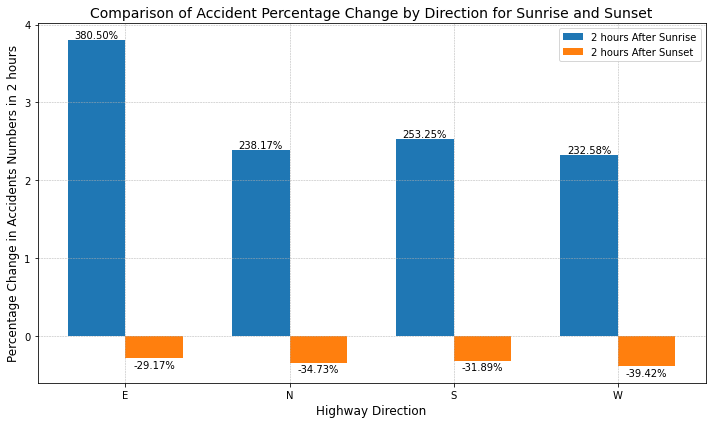

<Figure size 432x288 with 0 Axes>

In [25]:
# Now let's compare the percentage change in number of accidents for each direction for both sunrise and sunset
# Set up the figure
plt.figure(figsize=(10, 6))

# The number of bars per group
n_bars = len(percent_change_sunrise)

# The width of a single bar
bar_width = 0.35

# Set up the index for the bars
index = np.arange(n_bars)

# Plotting the sunrise data
sunrise_bars = plt.bar(index, percent_change_sunrise.values, bar_width, label='2 hours After Sunrise')

# Plotting the sunset data
sunset_bars = plt.bar(index + bar_width, percent_change_sunset.values, bar_width, label='2 hours After Sunset')

# Adding labels, title and legend
plt.xlabel('Highway Direction', fontsize=12)
plt.ylabel('Percentage Change in Accidents Numbers in 2 hours', fontsize=12)
plt.title('Comparison of Accident Percentage Change by Direction for Sunrise and Sunset', fontsize=14)
plt.legend()

# Set the position of the x ticks
plt.xticks(index + bar_width / 2, percent_change_sunrise.index)

# Show the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Function to add labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        label_position = height if height > 0 else height - 0.15
        plt.text(bar.get_x() + bar.get_width() / 2, label_position, f'{height:.2%}', ha='center', va='bottom')

# Adding labels to the bars
add_labels(sunrise_bars)
add_labels(sunset_bars)

# Ensure layout is tight so labels/titles are not cut off
plt.tight_layout()

# Show the plot
plt.show()

# save the plot
plt.savefig('./graph/comparison_of_accident_percentage_change_by_direction_for_sunrise_and_sunset.png', dpi=300)

This Plot compares the number of accidents in each direction 2 hours before and after sunrise and sunset. The x-axis represents the direction of travel, and the y-axis represents the percentage change in the number of accidents after sunrise or sunset compared to the number of accidents before sunrise or sunset.

Two noticeable trends are:
- A very high increase in accidents in the East direction after sunrise (380.50%).
- A significant decrease in accidents in the West direction after sunset (-39.42%).

The significant increase in accidents in the East direction after sunrise can be linked to the position of the sun. As the sun rises in the east, drivers traveling eastward are likely to face direct sun glare, which can impair vision and reaction times, leading to a higher risk of accidents. This issue is most pronounced shortly after sunrise when the sun is low on the horizon and potentially directly in the driver's line of sight. Conversely, the notable decrease in accidents in the West direction after sunset could be because drivers are no longer dealing with the intense glare from the setting sun. During the evening, particularly before sunset, the sun can be blinding for westward drivers, which may increase the chance of accidents. Once the sun has set, these conditions improve rapidly, thus potentially leading to a reduction in accidents. These trends suggest that the directionality of the sun relative to the highway plays a significant role in the frequency of accidents. They highlight the importance of considering natural light conditions when assessing road safety and designing preventive measures.